In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# Get data & split into train/test/validation sets

In [116]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst", "Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)



[[ 1.09706398 -2.07333501  1.56846633 ...  2.29607613  2.75062224
   1.93701461]
 [ 1.82982061 -0.35363241 -0.82696245 ...  1.0870843  -0.24388967
   0.28118999]
 [ 1.57988811  0.45618695  0.94221044 ...  1.95500035  1.152255
   0.20139121]
 ...
 [ 0.70228425  2.0455738  -0.84048388 ...  0.41406869 -1.10454895
  -0.31840916]
 [ 1.83834103  2.33645719  1.52576706 ...  2.28998549  1.91908301
   2.21963528]
 [-1.80840125  1.22179204 -3.11208479 ... -1.74506282 -0.04813821
  -0.75120669]]


In [117]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.20, stratify=label)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train)

# Create & Train Initial Model (no tuning)

Our initial model that we train, before hyperparameter tuning. We want a higher Recall, as it accounts for false negatives - and gives us a lower proportion of them, which we desire. We get a very high accuracy and recall and precision - which makes me suspect of overfitting, especially because we have such a small sample size respective to the number of features.

In [118]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

def bench_marks(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
bench_marks(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        72
           1       0.93      0.90      0.92        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

[[69  3]
 [ 4 38]]
Accuracy: 0.9385964912280702
Recall: 0.9047619047619048
Precision: 0.926829268292683


# Feature Selection
One 'feature' of Random Forest Classification is we can get the importance of each figure in the category - which can help us get rid of features with low utility and also make inferences from our results. We will remove our the lowest importance features using our importance series and recreate our train test sets.

In [119]:
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
feature_scores = feature_scores.index.tolist()
important_features = feature_scores[:-13]
feature = df[important_features]
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.20, stratify=label)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train)
print("\n")
print(important_features)

Concavity                0.261018
RadiusWorst              0.255495
ConcavePointsWorst       0.143964
Compactness              0.085238
CompactnessWorst         0.039247
Radius                   0.030152
ConcavityWorst           0.027801
CompactnessSE            0.019441
TextureWorst             0.014944
ConcavePoints            0.014416
FractalDimensionSE       0.014207
Smoothness               0.013656
ConcavitySE              0.012902
RadiusSE                 0.012169
SmoothnessWorst          0.008913
FractalDimension         0.008718
Texture                  0.008165
SymmetrySE               0.008085
SmoothnessSE             0.007693
TextureSE                0.004188
ConcavePointsSE          0.003511
FractalDimensionWorst    0.002617
Symmetry                 0.002225
SymmetryWorst            0.001233
dtype: float64


['Concavity', 'RadiusWorst', 'ConcavePointsWorst', 'Compactness', 'CompactnessWorst', 'Radius', 'ConcavityWorst', 'CompactnessSE', 'TextureWorst', 'ConcavePoints', 'Fr

We remove our features, and try our metrics again. We get a higher precision if we remove the least important features? Why is this happening? It also loses some accuracy. This makes me suspect of overfitting.

In [120]:
# test will validation
rfc = RandomForestClassifier(random_state=0, n_estimators=100)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_val)
bench_marks(y_val, y_pred)
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)


              precision    recall  f1-score   support

           0       0.95      0.91      0.93        57
           1       0.86      0.91      0.89        34

    accuracy                           0.91        91
   macro avg       0.90      0.91      0.91        91
weighted avg       0.91      0.91      0.91        91

[[52  5]
 [ 3 31]]
Accuracy: 0.9120879120879121
Recall: 0.9117647058823529
Precision: 0.8611111111111112
ConcavePoints         0.245996
ConcavePointsWorst    0.223143
RadiusWorst           0.194696
Radius                0.119006
ConcavityWorst        0.062448
Concavity             0.059117
TextureWorst          0.027783
Compactness           0.027048
CompactnessWorst      0.021035
CompactnessSE         0.009948
FractalDimensionSE    0.009779
dtype: float64


# Hyperparameter Tuning

We will use a random grib with a randomized search to try different iterations of the trees and brute force our way to a optimal solution. We will repeat the code below, adjusting the parameters each iteration.

In [121]:
n_estimators = [int(x) for x in range(10,100,1)]
max_depth = [int(x) for x in np.linspace(20, 150, num = 5)]
max_depth.append(None)
max_features = ['sqrt']
min_samples_split = [2, 3, 4, 5, 7, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [122]:
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)
rfc = rf_random.best_estimator_
#validation set
y_pred = rfc.predict(x_val)
print(rf_random.best_estimator_)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')
print(f'Precision: {precision_score(y_val, y_pred)}')
#actual test set
y_real_pred = rfc.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, y_real_pred)}')
print(f'Recall: {recall_score(y_test, y_real_pred)}')
print(f'Precision: {precision_score(y_test, y_real_pred)}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=117, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=69; total time=   0.1s
[CV] END bootstrap=False, max_depth=117, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=69; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=33; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=33; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=33; total time=   0.0s
[CV] END bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=81; total time=   0.1s
[CV] END bootstrap=False, max_depth=117, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estima

We will reduce the number of n_estimators (the number of trees in the forest) , as increasing them while reducing overfitting would increase our precision at the cost of our recall. Min_samples_leaf cannot be too small, as this will increase overfitting.

# Test for over/ underfitting

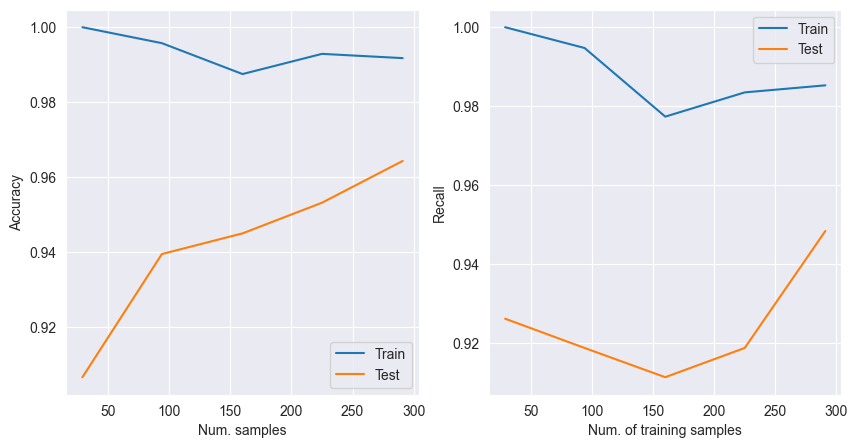

In [113]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='accuracy', cv=5)

train_sizes_abs_error, train_error, test_error = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='recall', cv=5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []

for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

##### before was
100% accuracy and not changing with the number of samples is clearly overfitting, so we will manually remove the least significant variables we calculated to simplify our model - so that we can make up for our lack of instances. When writing up this report, we can do these graphs twice - once with many variable and second with few. We get a higher recall, even though we get a lower precision and accuracy when we use less variables. #When writing up explain why each one

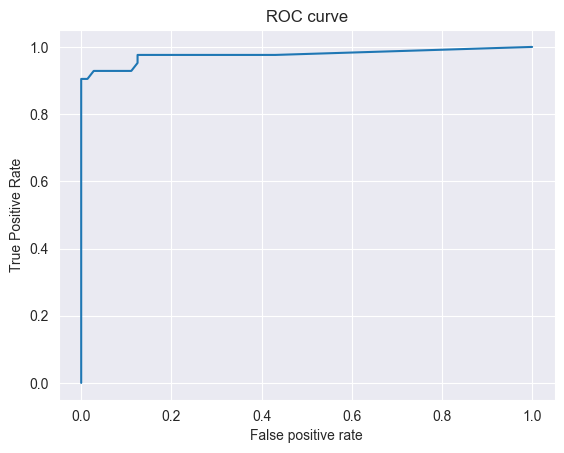

In [114]:
# After hyperparameter tuning* and feature selection*
y_real_pred = rfc.predict(x_test)
auc = roc_auc_score(y_test, y_real_pred)

y_pred_prob = rfc.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()


We want to minimise false positives..

How does this graph help us? IG I could manually calculate (using the graph) the precesion, accuracy and  recall stats to determine which point is best.